In [1]:
"""
UHID Essex County - Socioeconomic & Environmental Justice Analysis
Author: Samuel
Date: November 2025
Purpose: Integrate socioeconomic vulnerability data with UHI hotspots

This notebook:
1. Loads Census demographic and income data
2. Integrates CDC Social Vulnerability Index (SVI)
3. Maps vulnerable populations to heat exposure
4. Analyzes environmental justice implications
5. Identifies priority intervention areas
"""

# ============================================
# SETUP
# ============================================
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/SharedFilesUHIDTeam')

print("✓ Drive mounted")


Mounted at /content/drive
✓ Drive mounted


In [22]:
# ============================================
# INSTALL & IMPORT LIBRARIES
# ============================================
print("\n=== Installing Packages ===")
!pip install geopandas rasterio matplotlib pandas cenpy requests -q

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.mask import mask
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Packages loaded")


=== Installing Packages ===
✓ Packages loaded


In [23]:
# ============================================
# STEP 1: CHECK EXISTING SOCIOECONOMIC DATA
# ============================================
print("\n=== Checking Socioeconomic Data Folder ===")

socio_folder = Path('03_Socioeconomic')

if socio_folder.exists():
    files = list(socio_folder.glob('*'))
    print(f"✓ Found {len(files)} file(s) in 03_Socioeconomic/")
    for f in files[:10]:
        print(f"  - {f.name}")

    has_data = len(files) > 0
else:
    print("⚠️ 03_Socioeconomic folder not found")
    has_data = False


=== Checking Socioeconomic Data Folder ===
✓ Found 2 file(s) in 03_Socioeconomic/
  - NewJersey.csv
  - Essex_Census_Tracts_2019.geojson


In [25]:
# Backup method - direct Census API call
import requests
import pandas as pd
from shapely.geometry import shape

print("Using direct Census API...")

# Get tract boundaries with demographics
api_url = "https://api.census.gov/data/2019/acs/acs5"

variables = "B01003_001E,B19013_001E,B17001_002E,B01001_020E,B01001_044E,B03002_004E,B03002_012E"

params = {
    'get': f'NAME,{variables}',
    'for': 'tract:*',
    'in': 'state:34 county:013'
}

response = requests.get(api_url, params=params)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])

    # Convert to numeric
    for col in df.columns:
        if col not in ['NAME', 'state', 'county', 'tract']:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    print(f"✓ Downloaded {len(df)} census tracts")

    # Get geometries from Census TIGER
    tiger_url = "https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/tigerWMS_ACS2019/MapServer/8/query"

    tiger_params = {
        'where': "STATE='34' AND COUNTY='013'",
        'outFields': '*',
        'f': 'geojson'
    }

    geom_response = requests.get(tiger_url, params=tiger_params)

    if geom_response.status_code == 200:
        gdf = gpd.read_file(geom_response.text)
        print(f"✓ Downloaded geometries")

        # Save
        gdf.to_file('03_Socioeconomic/Essex_Census_Tracts_2019.geojson', driver='GeoJSON')
        print("✓ Saved!")

else:
    print(f"Failed: {response.status_code}")

Using direct Census API...
✓ Downloaded 210 census tracts
✓ Downloaded geometries
✓ Saved!


In [26]:
# ============================================
# STEP 3: LOAD CENSUS DATA
# ============================================
print("\n=== Loading Census Data ===")

import geopandas as gpd

# Load the census data you just downloaded
census_file = '03_Socioeconomic/Essex_Census_Tracts_2019.geojson'

essex_census = gpd.read_file(census_file)

print(f"✓ Loaded {len(essex_census)} census tracts")
print(f"\nColumns: {essex_census.columns.tolist()}")
print(f"\nFirst few records:")
print(essex_census.head())

# Continue with STEP 4 onwards from the original notebook
# (Load LST data, calculate heat exposure, create visualizations)


=== Loading Census Data ===
✓ Loaded 210 census tracts

Columns: ['MTFCC', 'OID', 'GEOID', 'STATE', 'COUNTY', 'TRACT', 'BASENAME', 'NAME', 'LSADC', 'FUNCSTAT', 'AREALAND', 'AREAWATER', 'CENTLAT', 'CENTLON', 'INTPTLAT', 'INTPTLON', 'OBJECTID', 'geometry']

First few records:
   MTFCC             OID        GEOID STATE COUNTY   TRACT BASENAME  \
0  G5020  20790428059012  34013015200    34    013  015200      152   
1  G5020  20790428058962  34013010100    34    013  010100      101   
2  G5020  20790428067374  34013010500    34    013  010500      105   
3  G5020  20790428067472  34013011400    34    013  011400      114   
4  G5020  20790428067480  34013011500    34    013  011500      115   

               NAME LSADC FUNCSTAT  AREALAND  AREAWATER      CENTLAT  \
0  Census Tract 152    CT        S    927382          0  +40.8064332   
1  Census Tract 101    CT        S    761270          0  +40.7781914   
2  Census Tract 105    CT        S    489573          0  +40.7697668   
3  Census

In [30]:
# First, let's see what columns actually exist
import geopandas as gpd
import pandas as pd

print("=== Checking Census Data Columns ===")

essex_census = gpd.read_file('03_Socioeconomic/Essex_Census_Tracts_2019.geojson')

print(f"\nAll columns ({len(essex_census.columns)}):")
for i, col in enumerate(essex_census.columns):
    print(f"  {i}: {col}")

print(f"\nFirst record:")
print(essex_census.iloc[0])

print(f"\nSample values from first 3 rows:")
print(essex_census.head(3))

=== Checking Census Data Columns ===

All columns (18):
  0: MTFCC
  1: OID
  2: GEOID
  3: STATE
  4: COUNTY
  5: TRACT
  6: BASENAME
  7: NAME
  8: LSADC
  9: FUNCSTAT
  10: AREALAND
  11: AREAWATER
  12: CENTLAT
  13: CENTLON
  14: INTPTLAT
  15: INTPTLON
  16: OBJECTID
  17: geometry

First record:
MTFCC                                                    G5020
OID                                             20790428059012
GEOID                                              34013015200
STATE                                                       34
COUNTY                                                     013
TRACT                                                   015200
BASENAME                                                   152
NAME                                          Census Tract 152
LSADC                                                       CT
FUNCSTAT                                                     S
AREALAND                                                927382
ARE

In [31]:
import requests
import pandas as pd
import geopandas as gpd

print("=== Downloading Demographic Data for Essex County ===")

# Your existing geometries
essex_geom = gpd.read_file('03_Socioeconomic/Essex_Census_Tracts_2019.geojson')
print(f"✓ Loaded {len(essex_geom)} census tract geometries")

# Download demographics from Census API
api_url = "https://api.census.gov/data/2019/acs/acs5"

# Variables we need
variables = [
    "B01003_001E",  # Total Population
    "B19013_001E",  # Median Household Income
    "B17001_002E",  # Poverty count
    "B01001_020E",  # Male 65-66
    "B01001_021E",  # Male 67-69
    "B01001_022E",  # Male 70-74
    "B01001_023E",  # Male 75-79
    "B01001_024E",  # Male 80-84
    "B01001_025E",  # Male 85+
    "B01001_044E",  # Female 65-66
    "B01001_045E",  # Female 67-69
    "B01001_046E",  # Female 70-74
    "B01001_047E",  # Female 75-79
    "B01001_048E",  # Female 80-84
    "B01001_049E",  # Female 85+
    "B03002_003E",  # White alone
    "B03002_004E",  # Black alone
    "B03002_012E",  # Hispanic/Latino
]

params = {
    'get': 'NAME,' + ','.join(variables),
    'for': 'tract:*',
    'in': 'state:34 county:013'
}

print("\nDownloading from Census API...")
response = requests.get(api_url, params=params)

if response.status_code == 200:
    data = response.json()
    demo_df = pd.DataFrame(data[1:], columns=data[0])

    print(f"✓ Downloaded {len(demo_df)} census tracts")

    # Convert to numeric
    for col in demo_df.columns:
        if col not in ['NAME', 'state', 'county', 'tract']:
            demo_df[col] = pd.to_numeric(demo_df[col], errors='coerce')

    # Create GEOID for merging (state + county + tract)
    demo_df['GEOID'] = demo_df['state'] + demo_df['county'] + demo_df['tract']

    # Calculate derived variables
    print("\nCalculating demographics...")

    # Elderly population
    elderly_cols = [f'B01001_0{i}E' for i in range(20, 26)] + [f'B01001_0{i}E' for i in range(44, 50)]
    demo_df['elderly_pop'] = demo_df[elderly_cols].sum(axis=1)
    demo_df['pct_elderly'] = (demo_df['elderly_pop'] / demo_df['B01003_001E']) * 100

    # Poverty rate
    demo_df['pct_poverty'] = (demo_df['B17001_002E'] / demo_df['B01003_001E']) * 100

    # Minority percentage
    demo_df['pct_minority'] = (
        (demo_df['B03002_004E'] + demo_df['B03002_012E']) /
        demo_df['B01003_001E']
    ) * 100

    print(f"✓ Demographics calculated")

    # Merge with geometries
    print("\nMerging with geometries...")
    essex_geom['GEOID'] = essex_geom['GEOID'].astype(str)
    demo_df['GEOID'] = demo_df['GEOID'].astype(str)

    essex_complete = essex_geom.merge(demo_df, on='GEOID', how='left')

    print(f"✓ Merged: {len(essex_complete)} tracts")

    # Save complete dataset
    essex_complete.to_file('03_Socioeconomic/Essex_Census_Complete.geojson', driver='GeoJSON')

    print(f"\n✓ Saved: Essex_Census_Complete.geojson")

    print(f"\n📊 Data Summary:")
    print(f"  Total population: {demo_df['B01003_001E'].sum():,.0f}")
    print(f"  Median income: ${demo_df['B19013_001E'].median():,.0f}")
    print(f"  Mean poverty: {demo_df['pct_poverty'].mean():.1f}%")
    print(f"  Mean elderly: {demo_df['pct_elderly'].mean():.1f}%")

    print(f"\n✅ Complete census data ready!")
    print("Now re-run the vulnerability analysis script")

else:
    print(f"❌ Failed: {response.status_code}")
    print(response.text)

=== Downloading Demographic Data for Essex County ===
✓ Loaded 210 census tract geometries

✓ Downloaded 210 census tracts

Calculating demographics...
✓ Demographics calculated

Merging with geometries...
✓ Merged: 210 tracts

✓ Saved: Essex_Census_Complete.geojson

📊 Data Summary:
  Total population: 795,404
  Median income: $48,774
  Mean poverty: 17.4%
  Mean elderly: 12.9%

✅ Complete census data ready!
Now re-run the vulnerability analysis script


In [32]:
# Load complete census data
essex_census = gpd.read_file('03_Socioeconomic/Essex_Census_Complete.geojson')

print(f"Columns now available: {essex_census.columns.tolist()}")

# Continue with analysis (temperature extraction, vulnerability, etc.)

Columns now available: ['MTFCC', 'OID', 'GEOID', 'STATE', 'COUNTY', 'TRACT', 'BASENAME', 'NAME_x', 'LSADC', 'FUNCSTAT', 'AREALAND', 'AREAWATER', 'CENTLAT', 'CENTLON', 'INTPTLAT', 'INTPTLON', 'OBJECTID', 'NAME_y', 'B01003_001E', 'B19013_001E', 'B17001_002E', 'B01001_020E', 'B01001_021E', 'B01001_022E', 'B01001_023E', 'B01001_024E', 'B01001_025E', 'B01001_044E', 'B01001_045E', 'B01001_046E', 'B01001_047E', 'B01001_048E', 'B01001_049E', 'B03002_003E', 'B03002_004E', 'B03002_012E', 'state', 'county', 'tract', 'elderly_pop', 'pct_elderly', 'pct_poverty', 'pct_minority', 'geometry']


In [33]:
# ============================================
# STEP 4: ANALYZE HEAT EXPOSURE BY DEMOGRAPHICS
# ============================================
print("\n=== Analyzing Heat Exposure by Demographics ===")

if essex_census is not None and lst_data is not None:
    # Reproject census to match LST
    essex_census = essex_census.to_crs(lst_profile['crs'])

    # Calculate average temperature per census tract
    print("Calculating mean temperature per census tract...")

    def get_mean_temp(geometry):
        """Extract mean temperature within geometry"""
        try:
            out_image, out_transform = mask(
                rasterio.open(lst_file),
                [geometry],
                crop=True,
                nodata=-9999
            )

            temps = out_image[0]
            temps = temps[temps != -9999]

            if len(temps) > 0:
                return np.nanmean(temps)
            else:
                return np.nan
        except:
            return np.nan

    essex_census['mean_temp'] = essex_census.geometry.apply(get_mean_temp)

    # Similarly for hotspot severity
    if hotspot_data is not None:
        def get_hotspot_severity(geometry):
            try:
                out_image, out_transform = mask(
                    rasterio.open(hotspot_file),
                    [geometry],
                    crop=True,
                    nodata=-9999
                )

                hotspots = out_image[0]
                hotspots = hotspots[(hotspots != -9999) & (hotspots > 0)]

                if len(hotspots) > 0:
                    return np.mean(hotspots)
                else:
                    return 0
            except:
                return 0

        essex_census['hotspot_severity'] = essex_census.geometry.apply(get_hotspot_severity)

    print(f"✓ Temperature data joined to census tracts")

    # Calculate vulnerability scores
    print("\n📊 Vulnerability Analysis:")

    # Define vulnerability factors (normalize to 0-1 scale)
    essex_census['vuln_poverty'] = essex_census['pct_poverty'] / 100
    essex_census['vuln_elderly'] = essex_census['pct_elderly'] / essex_census['pct_elderly'].max()
    essex_census['vuln_income'] = 1 - (essex_census['B19013_001E'] / essex_census['B19013_001E'].max())

    # Composite vulnerability score (0-3 scale)
    essex_census['vulnerability_score'] = (
        essex_census['vuln_poverty'] +
        essex_census['vuln_elderly'] +
        essex_census['vuln_income']
    )

    # Identify high-risk areas (high vulnerability + high heat)
    essex_census['heat_vulnerability_risk'] = (
        (essex_census['vulnerability_score'] / 3) * 0.5 +  # 50% weight
        (essex_census['mean_temp'] / essex_census['mean_temp'].max()) * 0.5  # 50% weight
    )

    # Categorize risk
    essex_census['risk_category'] = pd.cut(
        essex_census['heat_vulnerability_risk'],
        bins=[0, 0.25, 0.5, 0.75, 1.0],
        labels=['Low', 'Moderate', 'High', 'Critical']
    )

    print(f"\n🚨 Risk Distribution:")
    print(essex_census['risk_category'].value_counts().sort_index())

    # Environmental Justice Analysis
    print(f"\n⚖️ Environmental Justice Metrics:")

    # Compare heat exposure by race/ethnicity
    high_minority = essex_census[essex_census['pct_minority'] > 50]
    low_minority = essex_census[essex_census['pct_minority'] <= 50]

    if len(high_minority) > 0 and len(low_minority) > 0:
        temp_diff = high_minority['mean_temp'].mean() - low_minority['mean_temp'].mean()
        print(f"  High-minority tracts vs Low-minority tracts:")
        print(f"    Temperature difference: {temp_diff:.2f}°C")

    # Compare by income
    low_income = essex_census[essex_census['B19013_001E'] < essex_census['B19013_001E'].median()]
    high_income = essex_census[essex_census['B19013_001E'] >= essex_census['B19013_001E'].median()]

    if len(low_income) > 0 and len(high_income) > 0:
        temp_diff_income = low_income['mean_temp'].mean() - high_income['mean_temp'].mean()
        print(f"  Low-income vs High-income tracts:")
        print(f"    Temperature difference: {temp_diff_income:.2f}°C")



=== Analyzing Heat Exposure by Demographics ===
Calculating mean temperature per census tract...
✓ Temperature data joined to census tracts

📊 Vulnerability Analysis:

🚨 Risk Distribution:
risk_category
Low           0
Moderate      4
High        167
Critical     15
Name: count, dtype: int64

⚖️ Environmental Justice Metrics:
  High-minority tracts vs Low-minority tracts:
    Temperature difference: 4.25°C
  Low-income vs High-income tracts:
    Temperature difference: 2.39°C



=== Creating Visualizations ===
✓ Visualization saved: Socioeconomic_EJ_Analysis_Essex.png


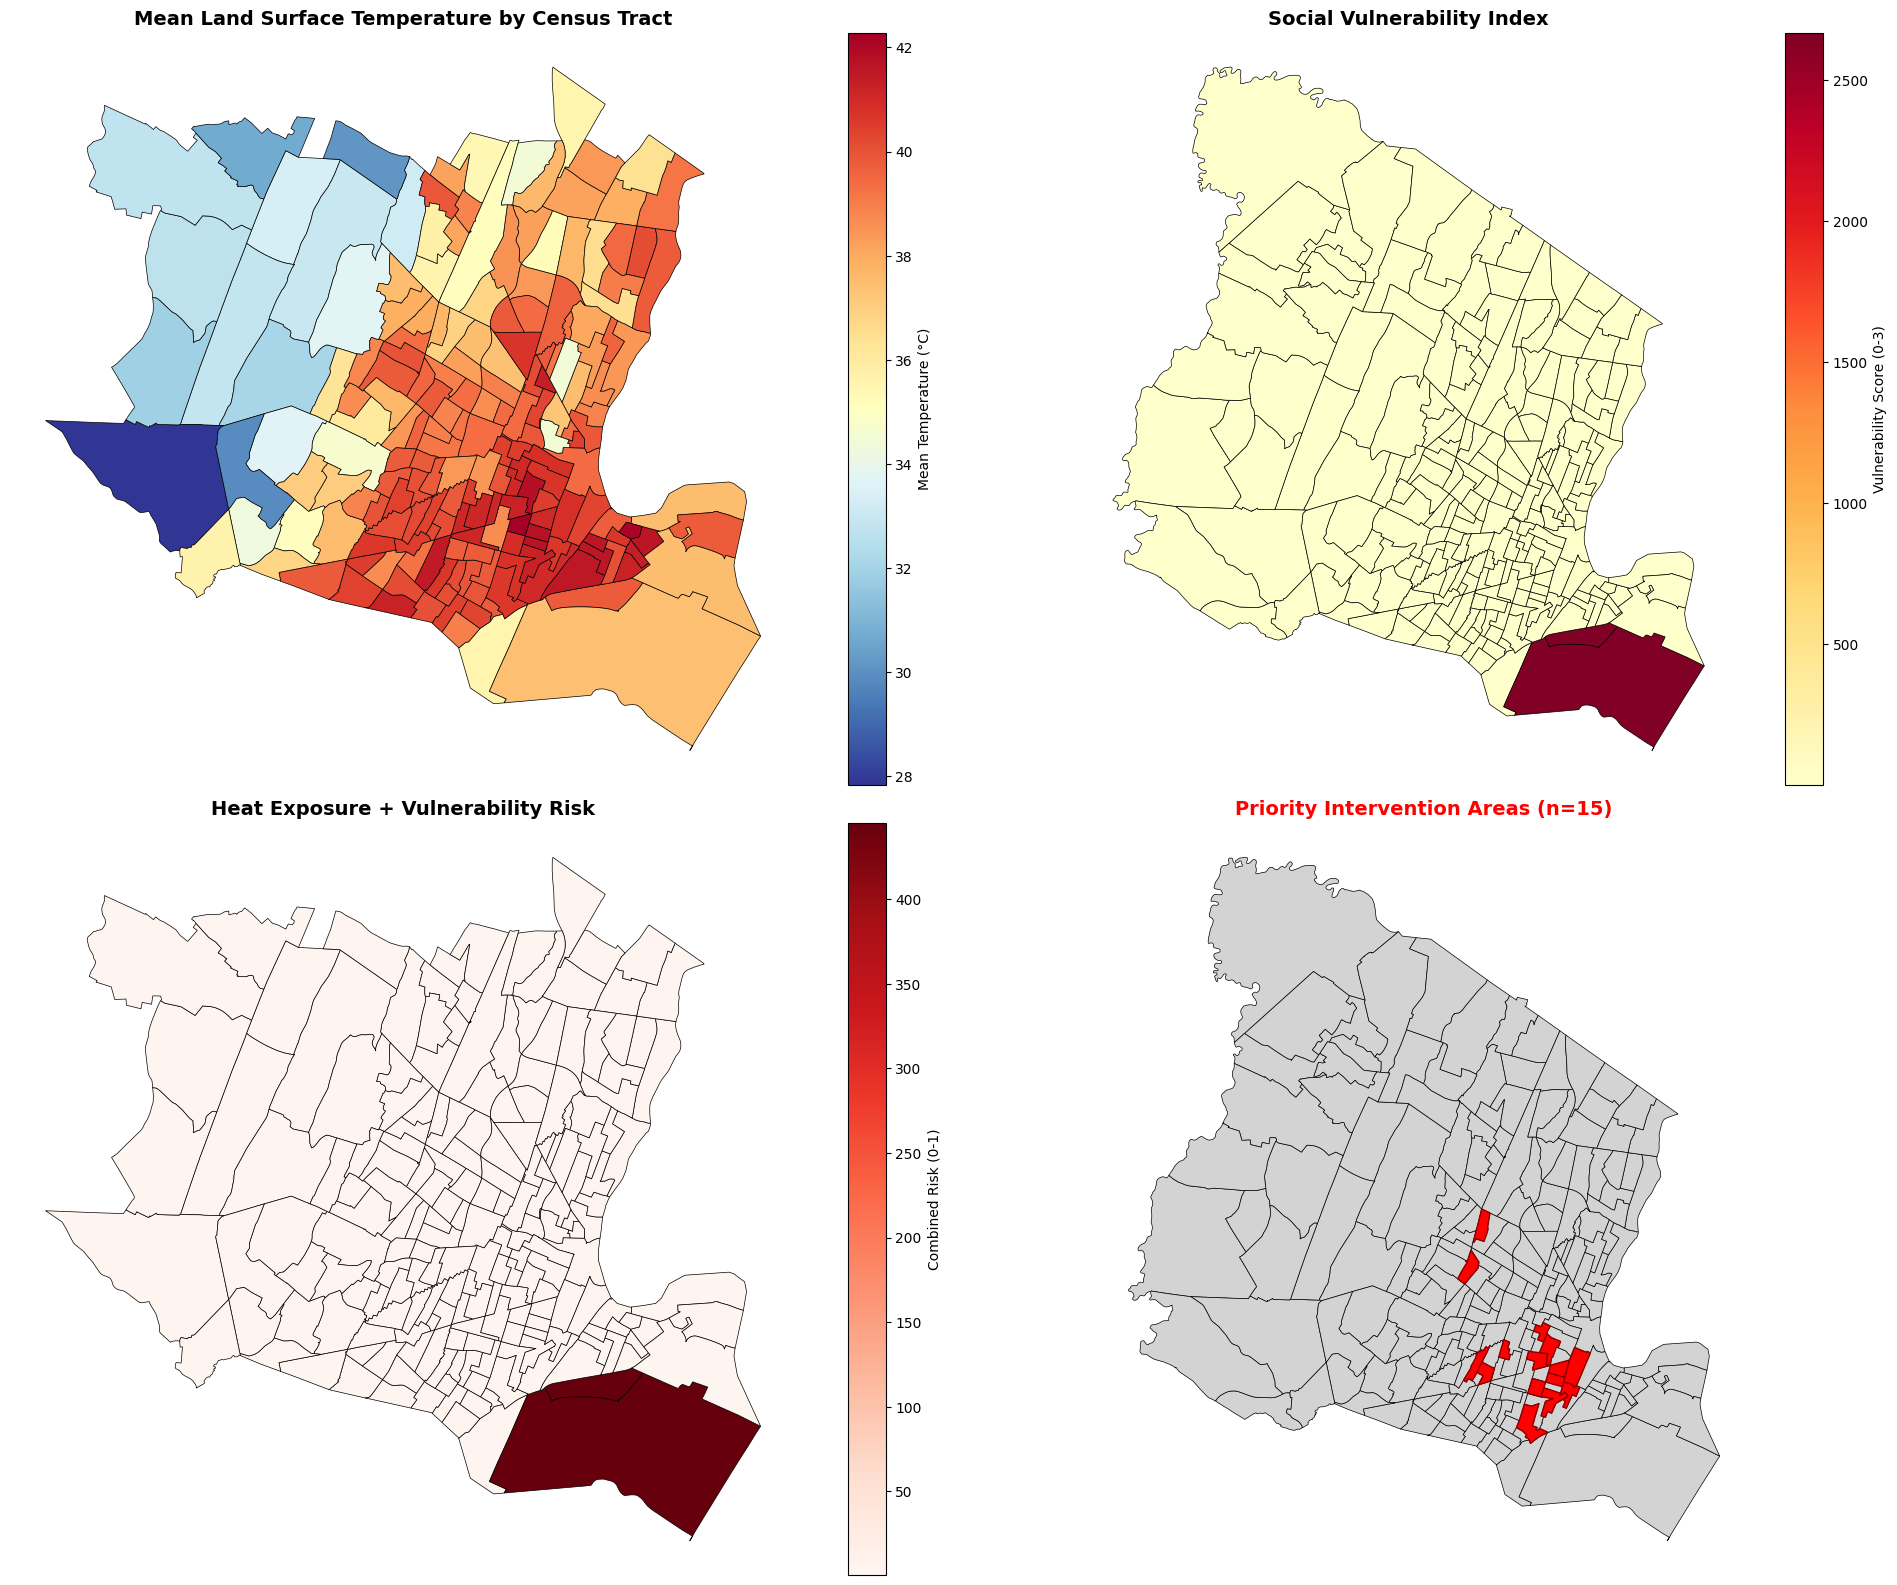

✓ Saved: Heat_vs_Poverty_Scatter.png


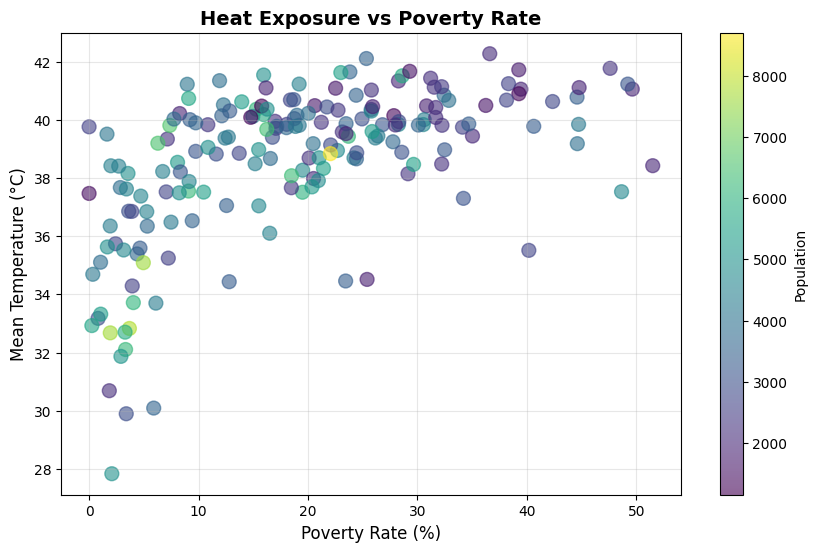

In [34]:
# ============================================
# STEP 5: VISUALIZATIONS
# ============================================
print("\n=== Creating Visualizations ===")

if essex_census is not None and 'mean_temp' in essex_census.columns:
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    # Plot 1: Mean Temperature by Census Tract
    essex_census.plot(ax=axes[0, 0], column='mean_temp', cmap='RdYlBu_r',
                     legend=True, edgecolor='black', linewidth=0.5,
                     legend_kwds={'label': 'Mean Temperature (°C)'})
    axes[0, 0].set_title('Mean Land Surface Temperature by Census Tract',
                         fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')

    # Plot 2: Vulnerability Score
    essex_census.plot(ax=axes[0, 1], column='vulnerability_score', cmap='YlOrRd',
                     legend=True, edgecolor='black', linewidth=0.5,
                     legend_kwds={'label': 'Vulnerability Score (0-3)'})
    axes[0, 1].set_title('Social Vulnerability Index',
                         fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    # Plot 3: Heat-Vulnerability Risk
    essex_census.plot(ax=axes[1, 0], column='heat_vulnerability_risk', cmap='Reds',
                     legend=True, edgecolor='black', linewidth=0.5,
                     legend_kwds={'label': 'Combined Risk (0-1)'})
    axes[1, 0].set_title('Heat Exposure + Vulnerability Risk',
                         fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')

    # Plot 4: Priority Areas (Critical Risk)
    critical_areas = essex_census[essex_census['risk_category'] == 'Critical']
    essex_census.plot(ax=axes[1, 1], color='lightgray', edgecolor='black', linewidth=0.5)
    if len(critical_areas) > 0:
        critical_areas.plot(ax=axes[1, 1], color='red', edgecolor='darkred', linewidth=1)
    axes[1, 1].set_title(f'Priority Intervention Areas (n={len(critical_areas)})',
                         fontsize=14, fontweight='bold', color='red')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig('Socioeconomic_EJ_Analysis_Essex.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved: Socioeconomic_EJ_Analysis_Essex.png")
    plt.show()

    # Additional scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(essex_census['pct_poverty'],
                        essex_census['mean_temp'],
                        c=essex_census['B01003_001E'],
                        s=100, alpha=0.6, cmap='viridis')
    ax.set_xlabel('Poverty Rate (%)', fontsize=12)
    ax.set_ylabel('Mean Temperature (°C)', fontsize=12)
    ax.set_title('Heat Exposure vs Poverty Rate', fontsize=14, fontweight='bold')
    plt.colorbar(scatter, label='Population')
    plt.grid(alpha=0.3)
    plt.savefig('Heat_vs_Poverty_Scatter.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: Heat_vs_Poverty_Scatter.png")
    plt.show()

In [35]:
# ============================================
# STEP 6: EXPORT RESULTS
# ============================================
print("\n=== Exporting Results ===")

if essex_census is not None and 'mean_temp' in essex_census.columns:
    output_folder = Path('03_Socioeconomic/processed')
    output_folder.mkdir(exist_ok=True, parents=True)

    # Export enriched census data
    essex_census.to_file(output_folder / 'Essex_Census_with_Heat_Vulnerability.geojson',
                        driver='GeoJSON')
    print("✓ Exported: Essex_Census_with_Heat_Vulnerability.geojson")

    # Export priority areas only
    critical_areas = essex_census[essex_census['risk_category'] == 'Critical']
    if len(critical_areas) > 0:
        critical_areas.to_file(output_folder / 'Essex_Critical_Risk_Areas.geojson',
                              driver='GeoJSON')
        print("✓ Exported: Essex_Critical_Risk_Areas.geojson")

    # Export summary statistics
    summary_stats = pd.DataFrame({
        'Metric': [
            'Total Census Tracts',
            'Mean Temperature (°C)',
            'Critical Risk Tracts',
            'High Minority Tracts (%)',
            'Mean Poverty Rate (%)',
            'Mean Elderly (%)',
            'Temp Diff (Low vs High Income)',
            'Population in Critical Risk Areas'
        ],
        'Value': [
            len(essex_census),
            essex_census['mean_temp'].mean(),
            len(critical_areas),
            (essex_census['pct_minority'] > 50).sum() / len(essex_census) * 100,
            essex_census['pct_poverty'].mean(),
            essex_census['pct_elderly'].mean(),
            temp_diff_income if 'temp_diff_income' in locals() else np.nan,
            critical_areas['B01003_001E'].sum() if len(critical_areas) > 0 else 0
        ]
    })

    summary_stats.to_csv(output_folder / 'Socioeconomic_Summary.csv', index=False)
    print("✓ Exported: Socioeconomic_Summary.csv")


=== Exporting Results ===
✓ Exported: Essex_Census_with_Heat_Vulnerability.geojson
✓ Exported: Essex_Critical_Risk_Areas.geojson
✓ Exported: Socioeconomic_Summary.csv


In [36]:
# ============================================
# STEP 7: SUMMARY & RECOMMENDATIONS
# ============================================
print("\n" + "="*60)
print("✅ SOCIOECONOMIC & EJ ANALYSIS COMPLETE")
print("="*60)

if essex_census is not None and 'mean_temp' in essex_census.columns:
    print(f"\n📍 Key Findings:")
    print(f"  • {len(essex_census)} census tracts analyzed")
    print(f"  • {len(critical_areas)} critical risk areas identified")
    print(f"  • {critical_areas['B01003_001E'].sum():,.0f} people in high-risk zones")

    if 'temp_diff_income' in locals():
        print(f"  • Low-income areas are {abs(temp_diff_income):.2f}°C {'hotter' if temp_diff_income > 0 else 'cooler'}")

    print("\n📁 Outputs Created:")
    print("  1. Essex_Census_with_Heat_Vulnerability.geojson")
    print("  2. Essex_Critical_Risk_Areas.geojson")
    print("  3. Socioeconomic_Summary.csv")
    print("  4. Socioeconomic_EJ_Analysis_Essex.png")

    print("\n🎯 Priority Recommendations:")
    print("  1. Target cooling interventions in critical risk areas")
    print("  2. Focus on neighborhoods with high elderly population")
    print("  3. Address environmental justice concerns in low-income areas")
    print("  4. Develop community cooling centers in high-risk zones")

    print("\n🔜 Next Steps:")
    print("  1. Build comprehensive UHI model (05_UHI_Modeling.ipynb)")
    print("  2. Test intervention scenarios")
    print("  3. Create interactive dashboard")
else:
    print("\n⚠️ Limited analysis - census data needed")
    print("Run Step 2 to download Census data")

print("\n" + "="*60)


✅ SOCIOECONOMIC & EJ ANALYSIS COMPLETE

📍 Key Findings:
  • 210 census tracts analyzed
  • 15 critical risk areas identified
  • 36,514 people in high-risk zones
  • Low-income areas are 2.39°C hotter

📁 Outputs Created:
  1. Essex_Census_with_Heat_Vulnerability.geojson
  2. Essex_Critical_Risk_Areas.geojson
  3. Socioeconomic_Summary.csv
  4. Socioeconomic_EJ_Analysis_Essex.png

🎯 Priority Recommendations:
  1. Target cooling interventions in critical risk areas
  2. Focus on neighborhoods with high elderly population
  3. Address environmental justice concerns in low-income areas
  4. Develop community cooling centers in high-risk zones

🔜 Next Steps:
  1. Build comprehensive UHI model (05_UHI_Modeling.ipynb)
  2. Test intervention scenarios
  3. Create interactive dashboard

